In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:

    !pip install gymnasium moviepy optuna

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [2]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import optuna
#O sampler do optuna basicamente vai ditar como o optuna vai ajustando os parâmetros a cada iteração
from optuna.samplers import TPESampler # https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html

optuna.logging.set_verbosity(optuna.logging.WARNING) # Para esconder a verbosidade padrão do optuna

c:\Users\Multimegaman\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
VERBOSE = True

# Configurações
# NOME_AMBIENTE = "CliffWalking-v0"
MAXIMO_PASSOS = 9000
TAXA_APRENDIZADO = 0.2
DESCONTO = 0.95
EPSILON = 0.1
TEMPERATURA = 1.0

import envs #importa racetrack
envs = {
    "Racetrack": "RaceTrack-v0",  # ensure this env exists or adjust accordingly
    "Cliffwalking": "CliffWalking-v0",
    "Frozen": "FrozenLake-v1",
    "Taxi": "Taxi-v3"
}

In [4]:
def plot_multiple_results(resultados, log_scale=False):
    for grupo_nome, grupo_dados in resultados.items():

        plt.figure(figsize=(12, 6))
        plt.title(f"Resultados do grupo: {grupo_nome}")

        for politica_nome, recompensas in grupo_dados.items():
            plt.plot(recompensas, label=politica_nome)

        plt.xlabel("Passos")
        plt.ylabel("Recompensas")
        if log_scale:
            plt.yscale('log')
        plt.legend()
        plt.show()

In [5]:
# Politicas

def politica_epsilon_gulosa(Q, estado, num_acoes, epsilon):
    probabilidades = [ (epsilon / num_acoes) ] * num_acoes
    acao_gulosa = np.argmax(Q[estado])
    probabilidades[acao_gulosa] += (1.0 - epsilon)
    return probabilidades

def politica_softmax(Q, estado, temperatura=1.0):
    valores_exp = np.exp(Q[estado] / temperatura)
    return valores_exp / np.sum(valores_exp)

def selecionar_acao(Q, estado, politica, **kwargs):
    probabilidades = politica(Q, estado, **kwargs)
    return np.random.choice(len(probabilidades), p=probabilidades)

In [6]:
def executar_expected_sarsa(ambiente, max_passos, taxa_aprendizado=0.1, desconto=0.95,
                          politica_treinamento=politica_epsilon_gulosa, politica_alvo=politica_epsilon_gulosa,
                          parametros_politica=None, exibir=False):
    num_acoes = ambiente.action_space.n
    Q = np.zeros((ambiente.observation_space.n, num_acoes))
    recompensas_por_episodio = []

    parametros_politica = parametros_politica or {}

    for i in tqdm(range(max_passos), desc=("Treinando Expected-SARSA -" + politica_treinamento.__name__ + " x " + politica_alvo.__name__)):
        concluido = False
        recompensa_total = 0
        estado, _ = ambiente.reset()
        passos = 0  # Inicializa o contador de passos

        while not concluido and passos < 3000:  # Limita os passos dentro de cada episódio
            if exibir and (i >= (max_passos - 5) or (i+1) % 1000 == 0):
                ambiente.render()

            acao = selecionar_acao(Q, estado, politica_treinamento, **parametros_politica)
            proximo_estado, recompensa, terminou, truncado, _ = ambiente.step(acao)
            concluido = terminou or truncado

            # Cálculo do valor esperado usando a política alvo
            if terminou:
                valor_proximo_estado = 0
            else:
                prob_alvo = politica_alvo(Q, proximo_estado, **parametros_politica)
                valor_proximo_estado = np.sum(prob_alvo * Q[proximo_estado])

            # Atualização Q-value
            delta = (recompensa + desconto * valor_proximo_estado) - Q[estado, acao]
            Q[estado, acao] += taxa_aprendizado * delta

            recompensa_total += recompensa
            estado = proximo_estado
            passos += 1

        recompensas_por_episodio.append(recompensa_total)
    print("Treinamento concluído. Resultado médio: ", np.mean(recompensas_por_episodio))
    return recompensas_por_episodio, Q

In [7]:
# Função objetivo para ser otimizada pelo Optuna
def objective(trial, env_name, policy_name, max_passos):
    """Função objetivo para otimização de hiperparâmetros com Optuna"""
    taxa_aprendizado = trial.suggest_float('taxa_aprendizado', 1e-3, 0.5, log=True)
    desconto = trial.suggest_float('desconto', 0.8, 0.999)
    
    params = {
        'taxa_aprendizado': taxa_aprendizado,
        'desconto': desconto,
    }
    
    # Hiperparâmetros específicos por política
    if policy_name == "epsilon-gulosa":
        params['epsilon'] = trial.suggest_float('epsilon', 0.01, 0.5)
    elif policy_name == "softmax":
        params['temperatura'] = trial.suggest_float('temperatura', 0.1, 10.0)
    
    # Configurar ambiente e políticas
    ambiente = gym.make(env_name, max_episode_steps=500)
    politicas = {
        "softmax": lambda Q, s, **kw: politica_softmax(Q, s, kw['temperatura']),
        "aleatoria": lambda Q, s, **kw: np.ones(len(Q[s])) / len(Q[s]),
        "epsilon-gulosa": lambda Q, s, **kw: politica_epsilon_gulosa(Q, s, len(Q[s]), kw['epsilon']),
    }
    
    # Executar treino com parâmetros atuais
    recompensas, _ = executar_expected_sarsa(
        ambiente, 
        max_passos= max_passos,
        taxa_aprendizado=params['taxa_aprendizado'],
        desconto=params['desconto'],
        politica_treinamento=politicas[policy_name],
        politica_alvo=politicas[policy_name],
        parametros_politica=params,
        exibir=False
    )
    
    return np.mean(recompensas[-100:])  # Média das últimas 100 recompensas

In [8]:
def otimizar_hiperparametros(envs, n_trials=50, max_passos=1000):
    """Otimiza hiperparâmetros para cada ambiente e política"""
    best_params = {}
    
    for env_label, env_name in envs.items():
        print(f"\n=== Otimizando {env_label} ===")
        env_params = {}
        
        for policy in ["epsilon-gulosa", "softmax", "aleatoria"]:
            study = optuna.create_study(
                direction='maximize',
                sampler=TPESampler(seed=42),
                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
            )
            study.optimize(
                lambda trial: objective(trial, env_name, policy, max_passos),
                n_trials=n_trials,
                show_progress_bar=False,  # Desativa a barra de progresso
                n_jobs= 1
            )
            
            # Armazenar melhores parâmetros
            env_params[policy] = {
                **study.best_params,
                'taxa_aprendizado': study.best_params['taxa_aprendizado'],
                'desconto': study.best_params['desconto']
            }
        
        best_params[env_label] = env_params
        print(f"Melhores parâmetros para {env_label}: {env_params}")
    
    return best_params

In [9]:
def executar_experimentos(nome_ambiente, best_params):
    """Executa experimentos com os melhores parâmetros encontrados"""
    ambiente = gym.make(nome_ambiente, max_episode_steps=500)
    politicas = {
        "epsilon-gulosa": lambda Q, s, **kw: politica_epsilon_gulosa(Q, s, len(Q[s]), kw['epsilon']),
        "softmax": lambda Q, s, **kw: politica_softmax(Q, s, kw['temperatura']),
        "aleatoria": lambda Q, s, **kw: np.ones(len(Q[s])) / len(Q[s])
    }

    grupos = [
        ("1) TODOS x random", "aleatoria"),
        ("2) TODOS x epsilon-greedy", "epsilon-gulosa"),
        ("3) TODOS x softmax", "softmax")
    ]

    resultados = {}

    for nome_grupo, politica_alvo_nome in grupos:
        print(f"\n=== {nome_grupo} ===")
        grupo_resultados = {}

        for politica_treinamento_nome in politicas:
            # Usar parâmetros do treino (taxa, desconto) e parâmetros específicos da política alvo
            params = {
                **best_params[politica_treinamento_nome],  # taxa_aprendizado e desconto
                **best_params[politica_alvo_nome]         # adiciona parâmetros da política alvo (epsilon/temperatura)
            }

            recompensas, _ = executar_expected_sarsa(
                ambiente, 
                MAXIMO_PASSOS,
                taxa_aprendizado=params['taxa_aprendizado'],
                desconto=params['desconto'],
                politica_treinamento=politicas[politica_treinamento_nome],
                politica_alvo=politicas[politica_alvo_nome],
                parametros_politica=params  # Garante que 'epsilon' ou 'temperatura' estejam presentes
            )
            
            grupo_resultados[politica_treinamento_nome] = recompensas
        
        resultados[nome_grupo] = grupo_resultados

    # Identificar melhores de cada grupo
    final_results = {}
    for grupo_nome, grupo_dados in resultados.items():
        medias = {k: np.mean(v[-100:]) for k, v in grupo_dados.items()}  # Média dos últimos 100 episódios
        melhor = max(medias, key=medias.get)
        final_results[f"{grupo_nome} ({melhor})"] = grupo_dados[melhor]

    resultados["FINAL) Melhores de cada grupo"] = final_results
    
    return resultados

In [10]:
import matplotlib.pyplot as plt
from util.plot import smooth  # use the smooth function from util/plot.py

def plot_grouped_results(resultados, log_scale=False, smooth_window=None):
    num_groups = len(resultados)
    # Create one subplot per group in the same figure
    fig, axes = plt.subplots(1, num_groups, figsize=(6 * num_groups, 5)) if num_groups > 1 else plt.subplots(figsize=(6, 5))
    if num_groups == 1:
        axes = [axes]
        
    for ax, (grupo_nome, grupo_dados) in zip(axes, resultados.items()):
         ax.set_title(f"Resultados do grupo: {grupo_nome}")
         for politica_nome, recompensas in grupo_dados.items():
              # Apply smoothing if requested
              data = smooth(recompensas, smooth_window) if smooth_window is not None else recompensas
              ax.plot(data, label=politica_nome)
         ax.set_xlabel("Passos")
         ax.set_ylabel("Recompensas")
         if log_scale:
             ax.set_yscale("log")
         ax.legend()
    plt.tight_layout()
    plt.show()


=== Otimizando Racetrack ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:00<00:00, 418.41it/s]


Treinamento concluído. Resultado médio:  -43.77


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:01<00:00, 92.57it/s]


Treinamento concluído. Resultado médio:  -183.44


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:01<00:00, 99.37it/s]


Treinamento concluído. Resultado médio:  -188.14
Melhores parâmetros para Racetrack: {'epsilon-gulosa': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'epsilon': 0.3686770314875885}, 'softmax': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'temperatura': 7.34674002393291}, 'aleatoria': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733}}

=== Otimizando Cliffwalking ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:00<00:00, 109.01it/s]


Treinamento concluído. Resultado médio:  -555.9


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:01<00:00, 58.61it/s]


Treinamento concluído. Resultado médio:  -705.07


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:01<00:00, 50.80it/s]


Treinamento concluído. Resultado médio:  -5184.46
Melhores parâmetros para Cliffwalking: {'epsilon-gulosa': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'epsilon': 0.3686770314875885}, 'softmax': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'temperatura': 7.34674002393291}, 'aleatoria': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733}}

=== Otimizando Frozen ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:00<00:00, 1960.80it/s]


Treinamento concluído. Resultado médio:  0.0


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:00<00:00, 2778.00it/s]


Treinamento concluído. Resultado médio:  0.01


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:00<00:00, 3030.39it/s]


Treinamento concluído. Resultado médio:  0.01
Melhores parâmetros para Frozen: {'epsilon-gulosa': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'epsilon': 0.3686770314875885}, 'softmax': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'temperatura': 7.34674002393291}, 'aleatoria': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733}}

=== Otimizando Taxi ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:01<00:00, 54.12it/s]


Treinamento concluído. Resultado médio:  -934.71


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:02<00:00, 46.65it/s]


Treinamento concluído. Resultado médio:  -1658.64


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 100/100 [00:02<00:00, 48.49it/s]


Treinamento concluído. Resultado médio:  -1799.21
Melhores parâmetros para Taxi: {'epsilon-gulosa': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'epsilon': 0.3686770314875885}, 'softmax': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'temperatura': 7.34674002393291}, 'aleatoria': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733}}

=== Executando experimentos para Racetrack ===

=== 1) TODOS x random ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:06<00:00, 137.85it/s]


Treinamento concluído. Resultado médio:  -137.7722222222222


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:09<00:00, 96.58it/s] 


Treinamento concluído. Resultado médio:  -186.13444444444445


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:08<00:00, 104.78it/s]


Treinamento concluído. Resultado médio:  -186.54222222222222

=== 2) TODOS x epsilon-greedy ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:06<00:00, 139.91it/s]


Treinamento concluído. Resultado médio:  -136.65555555555557


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:09<00:00, 90.24it/s] 


Treinamento concluído. Resultado médio:  -190.45222222222222


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:09<00:00, 96.61it/s] 


Treinamento concluído. Resultado médio:  -185.64

=== 3) TODOS x softmax ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:06<00:00, 134.81it/s]


Treinamento concluído. Resultado médio:  -137.76555555555555


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:10<00:00, 89.69it/s] 


Treinamento concluído. Resultado médio:  -198.3388888888889


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:09<00:00, 96.94it/s] 


Treinamento concluído. Resultado médio:  -188.16222222222223

=== Executando experimentos para Cliffwalking ===

=== 1) TODOS x random ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:02<00:00, 309.76it/s]


Treinamento concluído. Resultado médio:  -150.7411111111111


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:07<00:00, 119.43it/s]


Treinamento concluído. Resultado médio:  -256.46666666666664


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:17<00:00, 52.67it/s]


Treinamento concluído. Resultado médio:  -4956.945555555556

=== 2) TODOS x epsilon-greedy ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:02<00:00, 313.73it/s]


Treinamento concluído. Resultado médio:  -177.45


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:08<00:00, 100.25it/s]


Treinamento concluído. Resultado médio:  -288.84555555555556


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:17<00:00, 50.36it/s]


Treinamento concluído. Resultado médio:  -4999.5344444444445

=== 3) TODOS x softmax ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:03<00:00, 246.55it/s]


Treinamento concluído. Resultado médio:  -351.87888888888887


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:08<00:00, 103.74it/s]


Treinamento concluído. Resultado médio:  -287.9533333333333


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:18<00:00, 49.54it/s]


Treinamento concluído. Resultado médio:  -4955.966666666666

=== Executando experimentos para Frozen ===

=== 1) TODOS x random ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:00<00:00, 2694.69it/s]


Treinamento concluído. Resultado médio:  0.011111111111111112


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:00<00:00, 3199.39it/s]


Treinamento concluído. Resultado médio:  0.02


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:00<00:00, 3437.48it/s]


Treinamento concluído. Resultado médio:  0.014444444444444444

=== 2) TODOS x epsilon-greedy ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:00<00:00, 2945.19it/s]


Treinamento concluído. Resultado médio:  0.0044444444444444444


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:00<00:00, 3044.97it/s]


Treinamento concluído. Resultado médio:  0.008888888888888889


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:00<00:00, 3237.53it/s]


Treinamento concluído. Resultado médio:  0.011111111111111112

=== 3) TODOS x softmax ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:00<00:00, 2513.99it/s]


Treinamento concluído. Resultado médio:  0.006666666666666667


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:00<00:00, 2801.63it/s]


Treinamento concluído. Resultado médio:  0.01888888888888889


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:00<00:00, 3157.96it/s]


Treinamento concluído. Resultado médio:  0.006666666666666667

=== Executando experimentos para Taxi ===

=== 1) TODOS x random ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:13<00:00, 67.64it/s]


Treinamento concluído. Resultado médio:  -727.2822222222222


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:18<00:00, 49.03it/s]


Treinamento concluído. Resultado médio:  -1336.2622222222221


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:18<00:00, 49.59it/s]


Treinamento concluído. Resultado médio:  -1820.8166666666666

=== 2) TODOS x epsilon-greedy ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:12<00:00, 69.43it/s]


Treinamento concluído. Resultado médio:  -694.3322222222222


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:19<00:00, 46.67it/s]


Treinamento concluído. Resultado médio:  -1335.9688888888888


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:19<00:00, 47.20it/s]


Treinamento concluído. Resultado médio:  -1792.6366666666668

=== 3) TODOS x softmax ===


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:14<00:00, 63.89it/s]


Treinamento concluído. Resultado médio:  -720.1388888888889


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:19<00:00, 46.89it/s]


Treinamento concluído. Resultado médio:  -1355.98


Treinando Expected-SARSA -<lambda> x <lambda>: 100%|██████████| 900/900 [00:19<00:00, 46.08it/s]


Treinamento concluído. Resultado médio:  -1840.1122222222223

=== Resultados para Racetrack ===


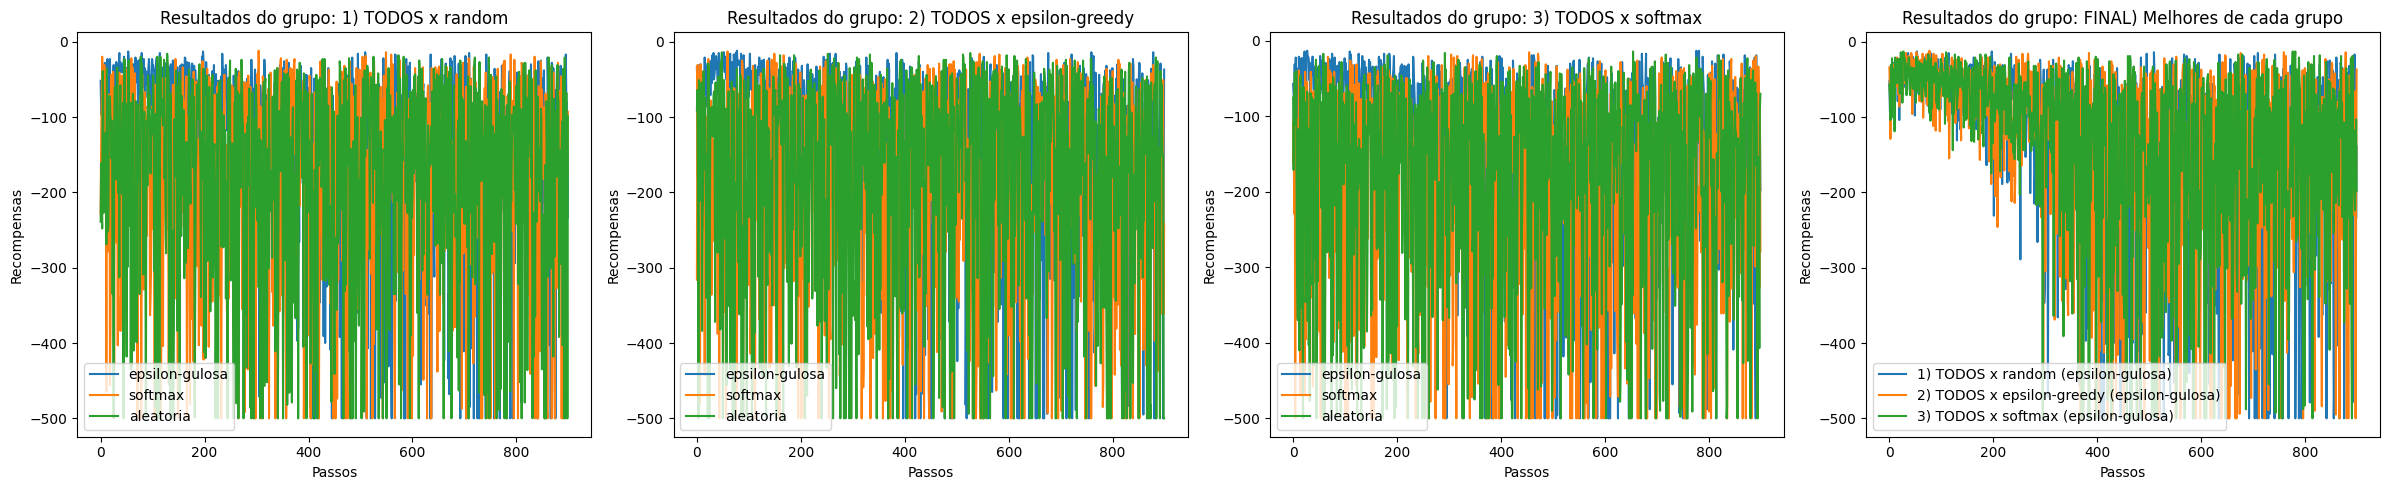


=== Resultados para Cliffwalking ===


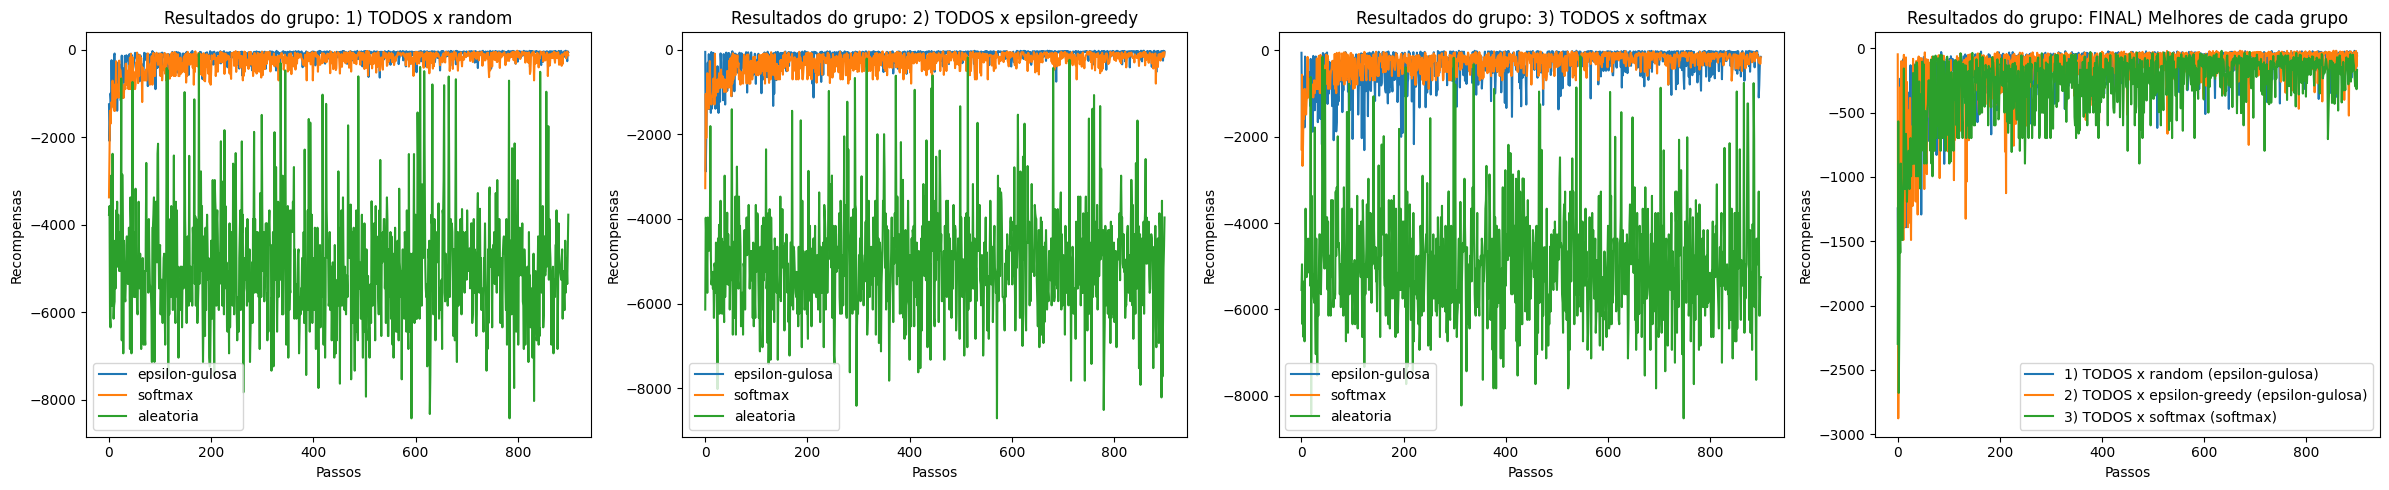


=== Resultados para Frozen ===


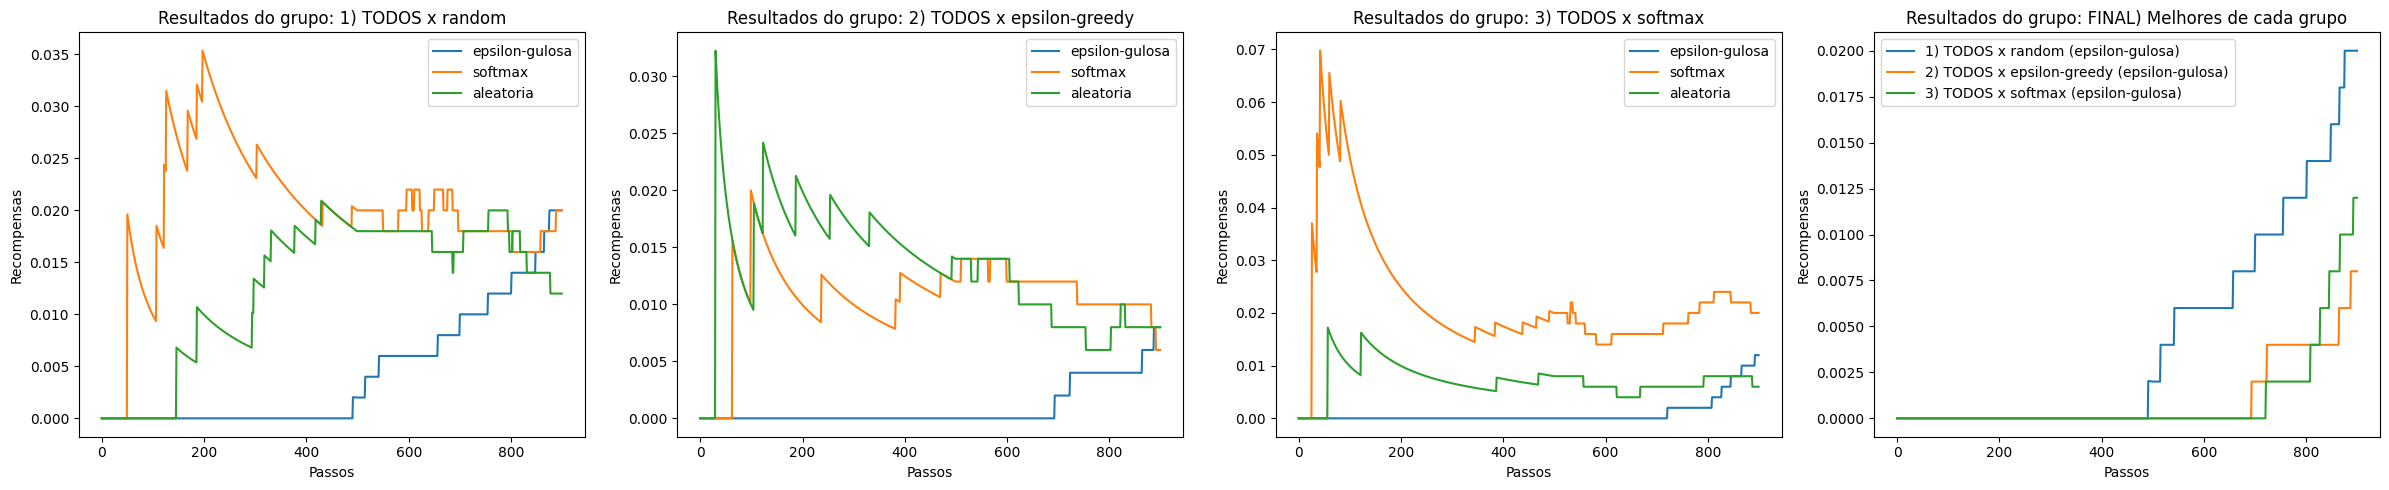


=== Resultados para Taxi ===


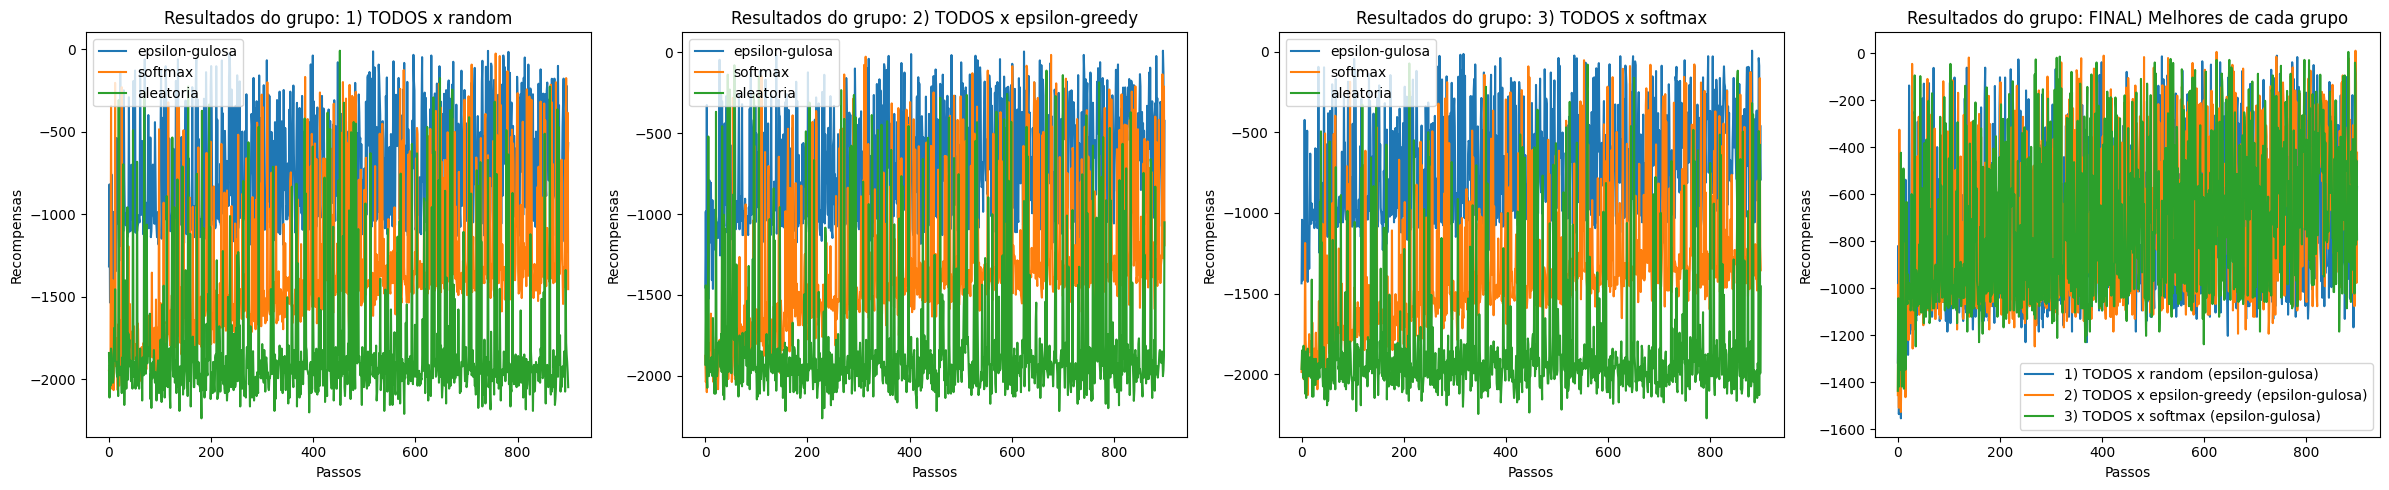

In [ ]:
# Fase 1: Otimização de hiperparâmetros
best_params = otimizar_hiperparametros(envs, n_trials=1, max_passos=1000)
# Fase 2: Execução dos experimentos com parâmetros otimizados
results_per_env = {}

for env_label, env_name in envs.items():
    #Pegando os melhores parâmetros para cada ambiente
    print(f"\n=== Executando experimentos para {env_label} ===")
    results = executar_experimentos(env_name, best_params[env_label])
    results_per_env[env_label] = results

# Fase 3: Plotagem dos resultados
for env_label, env_results in results_per_env.items():
    print(f"\n=== Resultados para {env_label} ===")
    if env_label == "Frozen":
        plot_grouped_results(env_results, log_scale=False, smooth_window=500)
    else:
        plot_grouped_results(env_results, log_scale=False)